In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler

In [2]:
DIR_PATH = "Semantic segmentation dataset/"
scaler = MinMaxScaler()
patch_size = 256

image_data = []

for path , subdirs, files in os.walk(DIR_PATH):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        for i, image_name in enumerate(images):
            #if image_name.endswith('.jpg'):
            image = cv2.imread(path+"/"+image_name, 1)
            width = (image.shape[1]//patch_size)*patch_size
            height = (image.shape[0]//patch_size)*patch_size

            image = Image.fromarray(image)      # convert the input image into PIL image object
            image = image.crop((0, 0, width, height))
            image = np.array(image)

            # Extract patches from each image

            #print('Now patchifying image:', path+"/"+image_name)
            patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)

            for i in range(patches.shape[0]):
                for j in range(patches.shape[1]):

                    single_patch_image = patches[i,j,:,:]

                    single_patch_image = scaler.fit_transform(single_patch_image.reshape(-1, single_patch_image.shape[-1])).reshape(single_patch_image.shape)

                    single_patch_image = single_patch_image[0]
                    image_data.append(single_patch_image)

In [3]:
mask_data = []

for path , subdirs, files in os.walk(DIR_PATH):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        for i, mask_name in enumerate(masks):
            #if image_name.endswith('.jpg'):
            mask = cv2.imread(path+"/"+mask_name, 1)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            width = (mask.shape[1]//patch_size)*patch_size
            height = (mask.shape[0]//patch_size)*patch_size

            mask = Image.fromarray(mask)      # convert the input image into PIL image object
            mask = mask.crop((0, 0, width, height))
            mask = np.array(mask)

            # Extract patches from each image
            
            #print('Now patchifying mask:', path+"/"+mask_name)
            patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):

                    single_patch_mask = patches_mask[i,j,:,:]

                    #single_patch_mask = scaler.fit_transform(single_patch_mask.reshape(-1, single_patch_mask.shape[-1])).reshape(single_patch_mask.shape)
                
                    single_patch_mask = single_patch_mask[0]
                    mask_data.append(single_patch_mask)

In [4]:
print(type(image_data))
print(len(image_data))
print(type(mask_data))
print(len(mask_data))

<class 'list'>
1305
<class 'list'>
1305


In [5]:
image_data = np.array(image_data)
mask_data = np.array(mask_data)

In [6]:
print(image_data.shape)
print(mask_data.shape)

(1305, 256, 256, 3)
(1305, 256, 256, 3)


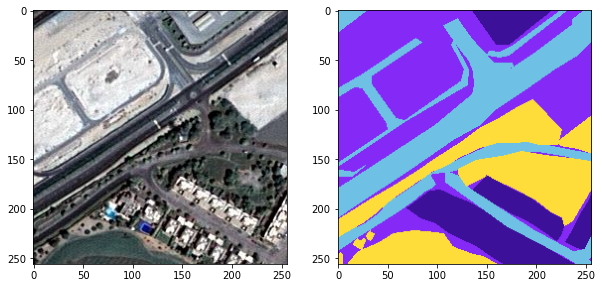

In [10]:
import random
sample = random.randint(0, len(image_data))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image_data[sample])
plt.subplot(122)
plt.imshow(mask_data[sample])
plt.show()

In [11]:


dict = {"Building" : "#3C1098",
"Land" : "#8429F6",
"Road" : "#6EC1E4",
"Vegetation" : "#FEDD3A",
"Water" : "#E2A929",
"Unlabeled" : "#9B9B9B"}


In [12]:
a = int('3A', 16) # convert HEX into int
a

58

In [13]:
RGB_label = {}
for key, value in dict.items():
    value = value.lstrip('#')
    RGB = np.array(tuple(int(value[i:i+2], 16) for i in (0, 2, 4)))
    RGB_label[key] = RGB

print(RGB_label)

{'Building': array([ 60,  16, 152]), 'Land': array([132,  41, 246]), 'Road': array([110, 193, 228]), 'Vegetation': array([254, 221,  58]), 'Water': array([226, 169,  41]), 'Unlabeled': array([155, 155, 155])}


In [14]:
def rgb_to_2d_label(label):
    
    label_array = np.zeros(label.shape, dtype=np.int8)

    for i, (key, value) in enumerate(RGB_label.items()):
        label_array[np.all(label == value, axis=-1)] = i

    label_array = label_array[:,:,0]    # take just first channel, no need of all 3 channel
    return label_array

In [15]:
labels = []

for i in range(mask_data.shape[0]):
    label = rgb_to_2d_label(mask_data[i])
    labels.append(label)

labels = np.array(labels)

In [16]:
labels.shape

(1305, 256, 256)

In [17]:
labels = np.expand_dims(labels, axis=3)
labels.shape

(1305, 256, 256, 1)

In [18]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=int8)

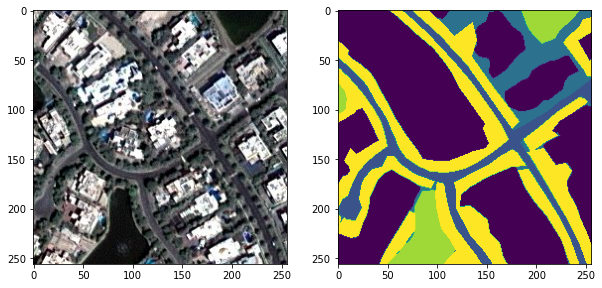

(256, 256, 1)


In [19]:
sample = random.randint(0, len(labels))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image_data[sample])
plt.subplot(122)
plt.imshow(mask_data[sample][:,:,0])
plt.show()
print(labels[sample].shape)

In [20]:
from keras.utils import to_categorical

num_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=num_classes)

In [21]:
labels_cat.shape

(1305, 256, 256, 6)

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_data, labels_cat, test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1044, 256, 256, 3),
 (261, 256, 256, 3),
 (1044, 256, 256, 6),
 (261, 256, 256, 6))

In [21]:
from unet_1 import build_unet
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3

input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
num_classes = 6

model = build_unet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer = 'adam', loss="categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "u_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [26]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("semantic_segmentation_aerial_satelite_images.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, mode='min')

history = model.fit(x_train, y_train, batch_size=1, epochs=25, validation_data=(x_test, y_test),
                    callbacks=[checkpoint_cb, early_stopping_cb], shuffle=False)

Epoch 1/25
1044/1044 [==============================] - 3377s 3s/step - loss: 1.0061 - accuracy: 0.6463 - val_loss: 0.8646 - val_accuracy: 0.6925
Epoch 2/25
1044/1044 [==============================] - 3572s 3s/step - loss: 0.8138 - accuracy: 0.7236 - val_loss: 0.8410 - val_accuracy: 0.6818
Epoch 3/25
1044/1044 [==============================] - 3273s 3s/step - loss: 0.7285 - accuracy: 0.7552 - val_loss: 0.8742 - val_accuracy: 0.6640
Epoch 4/25
1044/1044 [==============================] - 3726s 4s/step - loss: 0.6765 - accuracy: 0.7721 - val_loss: 0.8601 - val_accuracy: 0.6779


In [27]:
model.save("semantic_segmentation_aerial_satelite_images_1.h5")

In [23]:
# save the test data for prediction
import pickle

pickle_out = open("x_test.pickle", "wb")
pickle.dump(x_test, pickle_out)
pickle_out.close()

pickle_out = open("y_test.pickle", "wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()